<img src="https://pages.cnpem.br/capsuladaciencia/wp-content/uploads/sites/155/2022/10/Ilum.png" alt="Ilum - Escola de Ciência" width="200"/>

**Redes Neurais e Algoritmos Genéticos 2025**

**Prof. Dr. Daniel R. Cassar**

Rafael Dalacorte Erdmann (24017)

## Monstrinho 6: A curva de aprendizado

**Objetivo:** Implemente o registro da curva de aprendizado tanto dos dados de treino quanto de validação no código de redes neurais feito em Python puro nesta disciplina. Além de implementar, treine um modelo de rede neural em um conjunto de dados qualquer e mostre e interprete o gráfico das curvas de aprendizado.

**Comentário:** observe que o enunciado diz claramente que é para realizar a tarefa na rede neural feita em Python puro nos vídeos da disciplina. Se você está usando o `PyTorch`, `numpy`, `tensorflow`, `keras`, `lightning` ou qualquer outra biblioteca pronta, você está no caminho errado!

### Introdução

Uma curva de aprendizado é uma maneira gráfica de analisar o comportamento de um modelo em *machine learning* ao longo de diferentes quantidades de dados de treino ou de número de iterações (para algoritmos iterativos como o *backpropagation*) [1]. Nela, são evidenciados os valores da função de perda tanto do treino quanto da validação. Com isso, é possível analisar se o modelo está passando por *overfit* ao longo das iterações de treino e também se ele já convergiu (o que deve ocorrer em ambas curvas ao mesmo tempo), quando não há mais benefício em continuar treinando.

Para fazer isso, então, vamos precisar primeiro dividir os dados em um *set* de treino e outro de validação, para calcular suas funções de perda.

### Definição das Classes

Não há nada de novo nessa etapa, é apenas a importação das classes `Valor`, `Neurônio`, `Camada` e `MLP` já presentes em atividades anteriores.

In [110]:
import random
import numpy as np

class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = np.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

class Neuronio:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.sig()
        
        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]
    
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for i in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios 
        
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params
    
class MLP:   
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.epocas = 0
        self.curva_treino = []
        self.curva_validacao = []
        self.camadas = camadas
        
    def __call__(self, x):
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

### Exemplo de brinquedo e treinamento em épocas

Começaremos nossa solução primeiro com uma base de dados sintética e bem simples:

In [111]:
import numpy as np
from sklearn.model_selection import train_test_split

TAMANHO_TESTE = 0.25

SEMENTE_ALEATORIA = 42
random.seed(SEMENTE_ALEATORIA)

x = np.array([
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
])

y_true = np.array([1, 0, 0.2, 0.5])

# Normalização minmax
conversao = {}

for linha in range(len(x)):
    for coluna in range(len(x[linha,:])):
        maximox = max(x[:,coluna])
        minimox = min(x[:,coluna])

        conversao["x"+str(linha)+"_min"] = minimox
        conversao["x"+str(linha)+"_max"] = maximox

        def reconversao(y_norm, minimo, maximo):
            y_real = y_norm * (maximo - minimo) + minimo
            return y_real

        x[:,coluna] = (x[:,coluna] - minimox) / (maximox - minimox)
#

x = x.tolist()
y_true = y_true.tolist()

# Tratamento dos dados
indices = range(len(x))
indices_treino, indices_val = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=42
)

x_treino = [x[i] for i in indices_treino]
y_true_treino = [y_true[i] for i in indices_treino]

x_val = [x[i] for i in indices_val]
y_true_val = [y_true[i] for i in indices_val]
#

# Arquitetura da rede neural
NUM_DADOS_DE_ENTRADA = 3  
NUM_DADOS_DE_SAIDA = 1    
CAMADAS_OCULTAS = [3, 2]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]
todos_neuronios = [NUM_DADOS_DE_ENTRADA]+CAMADAS_OCULTAS+[NUM_DADOS_DE_SAIDA]

vies = []
for i in range(1, len(todos_neuronios)):
    vies.append([0]*todos_neuronios[i])

pesos = []
for i in range(1, len(todos_neuronios)):
    entradas = todos_neuronios[i-1]
    neuronios = todos_neuronios[i]
    pesos.append([[1]*entradas]*neuronios)

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)
#

Devemos, a seguir, editar nossa função de treino em épocas para incluir o cálculo da perda no *set* de validação. Para isso, basta adicionar as etapas respectivas durante o processamento de *forward pass* e da perda (*loss*). Apesar disso, a atualização dos gradientes locais ainda se baseia completamente no *set* de treino.

In [112]:
def treino_epocas(mlp:MLP, x_treino:list, x_val:list, y_true_treino:list, y_true_val:list, taxa_de_aprendizado:float, epocas=1000):
    """Função que realiza o treinamento em épocas de uma rede neural MLP. Para o quando o número de épocas alcançar o limite iter.
    
    Args:
        mlp: instância da classe MLP
        x_treino: lista com valores de features destinadas para treino
        x_val: lista com valores de features destinadas para validação
        y_true_treino: lista com valores de targets associados a cada linha de features dos dados de treino
        y_true_val: lista com valores de targets associados a cada linha de features dos dados de validação
        taxa_de_aprendizado: taxa de aprendizado do modelo, recomenda-se usar por volta de 0.5
        epocas: número de iterações do treinamento do modelo 
        
    Returns:
        não há retorno, a função atualiza os parâmetros da instância mlp"""

    curva_treino = []
    curva_validacao = []

    num_epocas = 0

    for _ in range(epocas):
        # forward pass
        ## forward pass do treino
        y_pred_treino = []

        for exemplo in x_treino:
            previsao = mlp(exemplo)
            y_pred_treino.append(previsao)

        ## forward pass da validação
        y_pred_val = []

        for exemplo in x_val:
            previsao = mlp(exemplo)
            y_pred_val.append(previsao)

        # loss
        ## loss do treino (RMSE)
        erros_treino = []
        for yt, yp in zip(y_true_treino, y_pred_treino):
            residuo = yp - yt
            erro_quadratico = residuo ** 2
            erros_treino.append(erro_quadratico)
        loss_treino = (sum(erros_treino)/len(y_true_treino))**(1/2)

        ## loss da validação (RMSE)
        erros_val = []
        for yt, yp in zip(y_true_val, y_pred_val):
            residuo = yp - yt
            erro_quadratico = residuo ** 2
            erros_val.append(erro_quadratico)
        loss_val = (sum(erros_val)/len(y_true_val))**(1/2)

        # zero grad
        for p in mlp.parametros():
            p.grad = 0

        # backpropagation
        loss_treino.propagar_tudo()

        # atualiza parâmetros
        for p in mlp.parametros():
            p.data = p.data - p.grad * taxa_de_aprendizado

        # SALVA o resultado
        curva_treino.append(loss_treino.data)
        curva_validacao.append(loss_val.data)
        num_epocas += 1 

    mlp.epocas += num_epocas
    mlp.curva_treino += curva_treino
    mlp.curva_validacao += curva_validacao

Chamando a função, o cálculo da curva de aprendizado será efetivamente realizado: em cada época de treinamento, serão feitas previsões com os dados de treino e previsões com os dados de validação, com suas respectivas perdas sendo salvas nos atributos `minha_mlp.curva_treino` e `minha_mlp.curva_validacao`.

In [113]:
TAXA_DE_APRENDIZADO = 0.5
NUM_EPOCAS = 700

treino_epocas(minha_mlp, x_treino, x_val, y_true_treino, y_true_val, taxa_de_aprendizado=TAXA_DE_APRENDIZADO, epocas=NUM_EPOCAS)

O resultado obtido pode ser visualizado pelo gráfico abaixo:

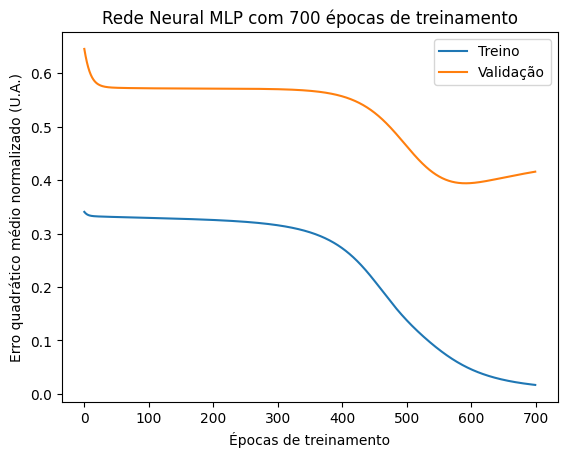

In [114]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots()

axes.plot(range(minha_mlp.epocas), minha_mlp.curva_treino, label="Treino")
axes.plot(range(minha_mlp.epocas), minha_mlp.curva_validacao, label="Validação")
axes.set_title(f"Rede Neural MLP com {minha_mlp.epocas} épocas de treinamento")
axes.set_ylabel("RMSE")
axes.set_xlabel("Épocas de treinamento")
axes.legend()
plt.show()

Com as curvas de treino e de validação, é possível perceber duas coisas essenciais: as duas curvas podem ser diferentes e a curva de validação pode crescer, o que categoriza *overfit* do modelo, ele está memorizando os dados de treino e perdendo poder de previsão.

### Novos dados

In [115]:
from sklearn.model_selection import train_test_split
import seaborn as sns

dados = sns.load_dataset("penguins")

TAMANHO_TESTE = 0.25

SEMENTE_ALEATORIA = 42
random.seed(SEMENTE_ALEATORIA)

dados = dados.loc[dados["species"]=="Adelie"].loc[dados["sex"]=="Male"].reset_index()

FEATURES = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']
TARGETS = ['body_mass_g']

# Normalização minmax
conversao = {}

for variavel in FEATURES+TARGETS:
    maximo = dados[variavel].max()
    minimo = dados[variavel].min()

    conversao[variavel+"_min"] = minimo
    conversao[variavel+"_max"] = maximo

    def reconversao(y_norm, minimo, maximo):
        y_real = y_norm * (maximo - minimo) + minimo
        return y_real

    dados[variavel] = (dados[variavel] - minimo) / (maximo - minimo)
#

# Tratamento dos dados
x = dados.reindex(FEATURES, axis=1)
y_true = dados.reindex(TARGETS, axis=1).values

indices = range(len(x))
indices_treino, indices_val = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=42
)

x_treino = x.loc[indices_treino].values.tolist()
y_true_treino = y_true[indices_treino].reshape(-1,1)

x_val = x.loc[indices_val].values.tolist()
y_true_val = y_true[indices_val].reshape(-1,1)
#

# Arquitetura da rede neural
NUM_DADOS_DE_ENTRADA = 3  
NUM_DADOS_DE_SAIDA = 1    
CAMADAS_OCULTAS = [3, 2]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede)
#

In [116]:
NUM_EPOCAS = 200
TAXA_DE_APRENDIZADO = 0.3

treino_epocas(minha_mlp, x_treino, x_val, y_true_treino, y_true_val, taxa_de_aprendizado=TAXA_DE_APRENDIZADO, epocas=NUM_EPOCAS)

Plotando a curva de aprendizado do teste

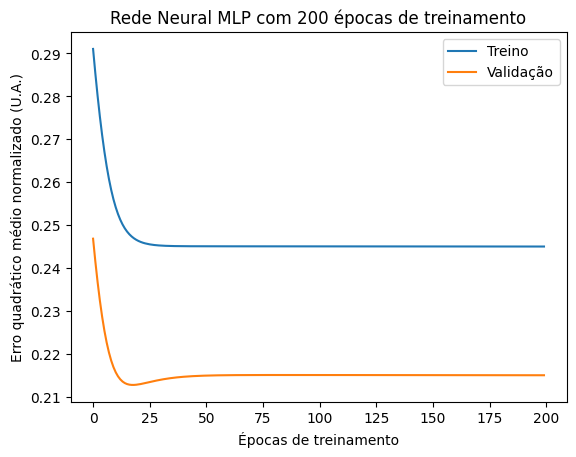

In [117]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots()

axes.plot(range(minha_mlp.epocas), minha_mlp.curva_treino, label="Treino")
axes.plot(range(minha_mlp.epocas), minha_mlp.curva_validacao, label="Validação")
axes.set_title(f"Rede Neural MLP com {minha_mlp.epocas} épocas de treinamento")
axes.set_ylabel("RMSE")
axes.set_xlabel("Épocas de treinamento")
axes.legend()
plt.show()

Observe que aqui temos dois problemas: após $50$ épocas, as perdas não estão mais reduzindo significativamente, o que pode dizer que convergimos para um mínimo local; e mais importante, a curva de validação atingiu um mínimo e depois cresceu novamente, de modo que o modelo pode estar apresentando *overfit* (isso será resolvido na Fera Formidável 2).

### Conclusão

A implementação da curva de aprendizado foi bem-sucedida, auxiliando na análise de convergência e *overfit*, conforme esperado.

### Referências

[1] Wikipedia. Learning curve (machine learning). Acesso em 10/06/2025. Disponível em: https://en.m.wikipedia.org/wiki/Learning_curve_%28machine_learning%29